In [ ]:
!pip install catboost
!pip install imblearn

# **Importing the dataset**
Checking no. of consumers who churned and who stayed

Check the shape of dataframe

Check info (data types of columns)

In [122]:
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("no. of churned customer : " )
print(df[df['Churn']=='Yes'].value_counts().sum())
print("\nno. of satisfied customer : " )
print(df[df['Churn']=='No'].value_counts().sum())

print("\ntotal consumers : ")
print(df.shape[0])

no. of churned customer : 
1869

no. of satisfied customer : 
5174

total consumers : 
7043


In [123]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [124]:
print(df.sample(5))

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
4341  3754-DXMRT    Male              1      No         No       2   
2589  7576-OYWBN    Male              1      No         No       3   
2558  5380-XPJNZ  Female              0      No         No      38   
5489  0804-XBFBV  Female              0      No        Yes      11   
4657  6743-HHQPF    Male              0     Yes         No      42   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
4341          Yes                No             DSL                   No  ...   
2589          Yes               Yes     Fiber optic                   No  ...   
2558          Yes                No              No  No internet service  ...   
5489           No  No phone service             DSL                   No  ...   
4657           No  No phone service             DSL                   No  ...   

         DeviceProtection          TechSupport          StreamingTV  \
4341                 

# **Pre-processing Techniques**
Import all libraries and required functions

Drop unnecessary features and replace missing values

(OHE & LE) Encode categorical data into [0 or 1]

Standardize the input data using standard_scaler

Creating a balanced dataset using SMOTE (Synthetic Minority Oversampling Technique)

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_score, roc_auc_score, f1_score, recall_score, roc_curve, auc, balanced_accuracy_score)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity

In [126]:
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

<ipython-input-126-1ee527dd8306>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [127]:
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
df = df.replace('No internet service', 'No')

internet_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# df = df.replace({'Yes': 1, 'No': 0})....................reduces accuracy maybe alters column which is not needed to be altered.
columns = ["Partner","Dependents","PhoneService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies", "PaperlessBilling", "Churn" ]
for i in columns:
  df[i] = df[i].map({'Yes': 1, 'No': 0})

In [128]:
binary_columns = ['gender']
le = LabelEncoder()
df[binary_columns] = df[binary_columns].apply(le.fit_transform)
df = pd.get_dummies(df, columns=['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])

scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [129]:
X = df.drop('Churn', axis=1)
y = df['Churn']
smote = SMOTE(random_state=50)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=48) #42 #48 - 0.8555555555555555

# **Implementing different kinds of Models**
Importing all libraries

Hyperparameter-tuning using GridSearchCV

Choose the model which performs the best

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [131]:
models = [('Logistice Regression', LogisticRegression(random_state=123456)),
          ('K-nearest Neighbours', KNeighborsClassifier()),
          ('Decision Tree', DecisionTreeClassifier(random_state=123456)),
          ('Random Forest', RandomForestClassifier(random_state=123456)),
          ('Support Vector Machine', SVC(gamma='auto',random_state=123456)),
          ('Gradient Boosting', GradientBoostingClassifier(random_state = 12345))          ]
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456, shuffle = True)
    cv_results = cross_val_score(model, X, y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy = %f " % (name, cv_results.mean())
    print(msg)

Logistice Regression: Accuracy = 0.804913 
K-nearest Neighbours: Accuracy = 0.765582 
Decision Tree: Accuracy = 0.723408 
Random Forest: Accuracy = 0.793834 
Support Vector Machine: Accuracy = 0.798522 
Gradient Boosting: Accuracy = 0.802780 


In [132]:
catboost_model = CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.11, loss_function='Logloss', verbose=0)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of CatBoost Model after SMOTE:", accuracy)

Accuracy of CatBoost Model after SMOTE: 0.8623188405797102


In [133]:
model = RandomForestClassifier(random_state=52)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred)}")

# .........................................................................................................

gb_model = GradientBoostingClassifier(learning_rate = 0.1, random_state = 50, n_estimators = 200, min_samples_split = 6, max_depth = 7)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
print(f"Gradient boosting Accuracy: {accuracy_score(y_test, gb_y_pred)}")

# .........................................................................................................

xgb_model = XGBClassifier(learning_rate=0.1, random_state=100, n_estimators=100, subsample=0.8, max_depth=9)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_y_pred)}")

Random Forest Accuracy: 0.8579710144927536
Gradient boosting Accuracy: 0.851207729468599
XGBoost Accuracy: 0.8555555555555555


# **The best performing models were :**

Random Forest Accuracy: 0.8579710144927536

CatBoost Accuracy: 0.8623188405797102

XGBoost Accuracy: 0.8555555555555555




### Now we will choose Catboost as our model, **get the most Important features** and proceed further towards the **recommender system**

In [134]:
catboost_model = CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.11, loss_function='Logloss', verbose=0)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
classification_report = classification_report(y_test, y_pred)
print("CatBoost Model result:\n", classification_report)

CatBoost Model result:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       976
           1       0.87      0.87      0.87      1094

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070



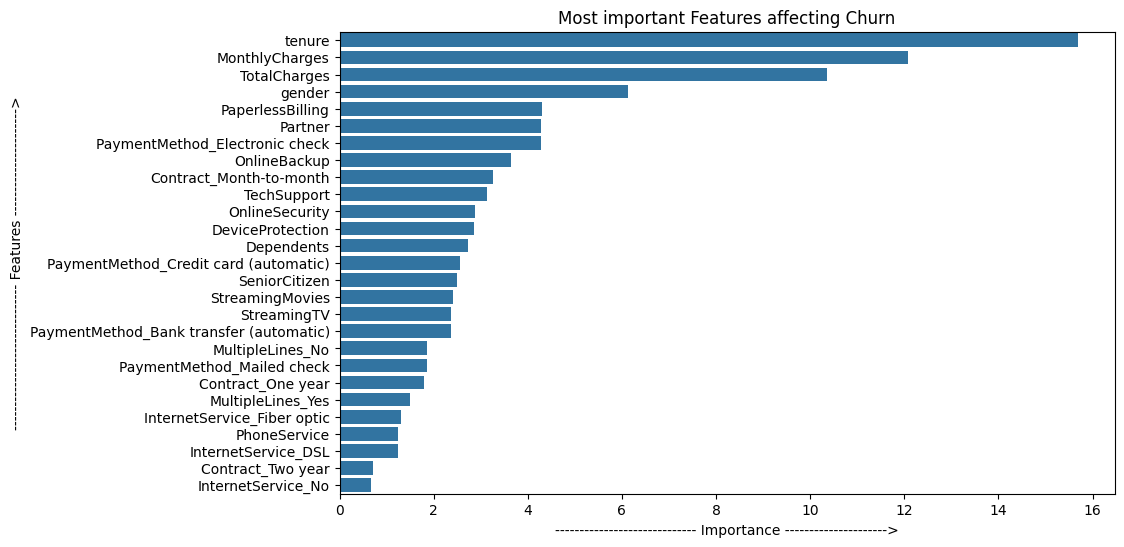

In [140]:
feature_importances = catboost_model.get_feature_importance()
features = X_train.columns

importance_df = pd.DataFrame({
    'Features': features,
    'Importance': feature_importances })
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Most important Features affecting Churn')
plt.xlabel('----------------------------- Importance --------------------->')
plt.ylabel('------------------------------ Features ---------------------->')
plt.show()

# **Recommender System**
Getting similarity between customer (cosine similarity)

Get customer details,customer's current services and prediction

Using similarity to generate recommendation based on services used and churn probability

In [136]:
def create_customer_profiles(X):
    return X


def get_similar_customers(customer_profiles, target_customer_idx, n=5):
    similarity_matrix = cosine_similarity(customer_profiles)
    similar_indices = similarity_matrix[target_customer_idx].argsort()[::-1][1:n+1]
    return similar_indices

In [137]:
def generate_recommendations(X, y, customer_profiles, target_customer_idx):
    similar_customers = get_similar_customers(customer_profiles, target_customer_idx)
    non_churned_similar = [idx for idx in similar_customers if y[idx] == 0]

    if not non_churned_similar:
        return None
    current_customer = X.iloc[target_customer_idx]
    similar_customers_data = X.iloc[non_churned_similar]

    recommendations = {}
    # ...........................Recommendation based on Contract period...............................
    contract_columns = [col for col in X.columns if 'Contract_' in col]
    current_contract = [col for col in contract_columns if current_customer[col] == 1][0].split('_')[1]
    avg_contract_usage = similar_customers_data[contract_columns].mean()
    recommended_contract = avg_contract_usage.idxmax().split('_')[1]

    if current_contract == 'Month-to-month':
        recommendations['Contract'] = "Consider offering a discounted long-term contract"

    #............................Recommendation based on Internet services used.........................
    internet_columns = [col for col in X.columns if 'InternetService_' in col]
    current_internet = [col for col in internet_columns if current_customer[col] == 1]
    current_internet = current_internet[0].split('_')[1] if current_internet else 'None'

    if current_internet == 'DSL':
        recommendations['InternetService'] = "Upgrade to Fiber optic service with a special promotion"
    elif current_internet == 'None':
        recommendations['InternetService'] = "Introduce internet service with a first-time customer discount"

    # ............................Recommendations based on other Additional services....................
    if current_customer['OnlineSecurity'] == 0:
        recommendations['OnlineSecurity'] = "Add online security features to the package"
    if current_customer['TechSupport'] == 0:
        recommendations['TechSupport'] = "Include premium technical support"
    if current_customer['DeviceProtection'] == 0:
        recommendations['DeviceProtection'] = "Add device protection plan"
    if current_customer['OnlineBackup'] == 0:
        recommendations['OnlineBackup'] = "Include online backup service"
    if current_customer['StreamingTV'] == 0 & current_customer['StreamingMovies'] == 0:
        recommendations['StreamingTV'] = "Suggest TV & Movies streaming services at discounted prices"
    return recommendations

In [138]:
def get_customer_insights(customer_id, X, y, catboost_model):
    if customer_id < 0 or customer_id >= len(X):
        return " !!! Invalid customer ID !!! "

    churn_prob = catboost_model.predict_proba(X.iloc[customer_id:customer_id+1])[0][1]
    customer_data = X.iloc[customer_id]

    customer_profiles = create_customer_profiles(X)
    recommendations = generate_recommendations(X, y, customer_profiles, customer_id)
    return {
        'churn_probability': churn_prob,
        'current_services': parse_current_services(customer_data),
        'recommendations': recommendations if recommendations else {}
    }

def parse_current_services(customer_data):
    services = {}
    # Contract type
    contract_cols = [col for col in customer_data.index if 'Contract_' in col]
    for col in contract_cols:
        if customer_data[col] == 1:
            services['Contract'] = col.split('_')[1]

    # Internet service
    internet_cols = [col for col in customer_data.index if 'InternetService_' in col]
    for col in internet_cols:
        if customer_data[col] == 1:
            services['InternetService'] = col.split('_')[1]

    # Additional services
    service_map = {
        'OnlineSecurity': 'Online Security',
        'OnlineBackup': 'Online Backup',
        'DeviceProtection': 'Device Protection',
        'TechSupport': 'Tech Support',
        'StreamingTV': 'Streaming TV',
        'StreamingMovies': 'Streaming Movies'    }

    services['AdditionalServices'] = [readable for service, readable in service_map.items()
                                     if customer_data[service] == 1]
    return services

In [142]:
def interactive_customer_recommendations():
    while True:
        try:
            customer_id = int(input("\nEnter customer ID (between 1 to 7043 or (-1) to exit): "))
            if customer_id == -1:
                print("Exiting recommender system...")
                print("Thank you for using our services")
                break

            insights = get_customer_insights(customer_id, X_res, y_res, catboost_model)
            if isinstance(insights, str):
                print(insights)
                continue
            print(f"\nCustomer {customer_id} Analysis")
            print("-" * 20)

#.................................Churn risk category........................................
            churn_prob = insights['churn_probability']
            if churn_prob < 0.3:
                risk_category = "Low Risk"
            elif churn_prob < 0.6:
                risk_category = "Medium Risk"
            else:
                risk_category = "High Risk"
            print(f"Costumer Churn Risk: {risk_category} ({churn_prob:.1%} probability)")

#....................................Current services..........................................
            print("\nCurrent Services:")
            current = insights['current_services']
            print(f"Contract Type: {current['Contract']}")
            print(f"Internet Service: {current.get('InternetService', 'None')}")
            if current['AdditionalServices']:
                print("Additional Services:", ", ".join(current['AdditionalServices']))
            else:
                print("Additional Services: None")

            if insights['recommendations']:
                print("\nRecommendations to Prevent Churn:")
                for category, recommendation in insights['recommendations'].items():
                    print(f"- {recommendation}")
            else:
                print("\nNo specific recommendations at this time.")

        except ValueError:
            print("enter valid customer ID (numeric value)")

print("Welcome to the Customer Churn Prevention System")
print("This system will provide personalized recommendations to prevent customer churn.")
interactive_customer_recommendations()

Welcome to the Customer Churn Prevention System
This system will provide personalized recommendations to prevent customer churn.

Enter customer ID (between 1 to 7043 or (-1) to exit): 1701

Customer 1701 Analysis
--------------------
Costumer Churn Risk: High Risk (89.1% probability)

Current Services:
Contract Type: One year
Internet Service: Fiber optic
Additional Services: Online Backup, Device Protection, Streaming TV, Streaming Movies

Recommendations to Prevent Churn:
- Add online security features to the package
- Include premium technical support

Enter customer ID (between 1 to 7043 or (-1) to exit): 613

Customer 613 Analysis
--------------------
Costumer Churn Risk: Low Risk (7.3% probability)

Current Services:
Contract Type: One year
Internet Service: Fiber optic
Additional Services: Online Security, Online Backup, Device Protection, Streaming TV, Streaming Movies

Recommendations to Prevent Churn:
- Include premium technical support

Enter customer ID (between 1 to 7043 